# US Immigration Data Warehouse

#### Project Summary
This project builds up a data warehouse by integrating immigration data, demography data and temperature data together.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

### Step 1: Scope the Project and Gather Data

#### Scope 
This project will integrate I94 immigration data, world temperature data and US demographic data to setup a data warehouse with fact and dimension tables.
##### Dataset
1. [I94 Immigration Data](https://www.trade.gov/national-travel-and-tourism-office)
> Data contains international visitor arrival statistics by world regions and select countries (including top 20), type of visa, mode of transportation, age groups, states visited (first intended address only), and the top ports of entry (for select countries).
2. [World Temperature Data](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data)
> This dataset is from Kaggle and contains monthly average temperature data at different country in the world wide.
3. [U.S. City Demographic Data](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/)
> This dataset contains information about the demographics of all US cities and census-designated places with a population greater or equal to 65,000.


### Step 2: Explore and Assess the Data
#### Explore the Data 
1. Headers are not easy to understand.
2. `arrival_date`, `departure_date` are SAS date format.
3. The headers in _U.S. City Demographic Data_ contain spaces which are note allowed in spark.
4. Some columns in `immigration_data_sample.csv` are useless in this case.

#### Cleaning Steps
1. Create a function `rename_columns` to rename the columns.
2. Create a function `convert_SAS_date` to convert the SAS date to calander date.
3. Use `rename_columns` to change the columns name.
4. Select the columns we want and create a new dataframe.

In [2]:
import pandas as pd
df_immi = pd.read_csv('immigration_data_sample.csv')
df_immi.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,...,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,...,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


In [3]:
df_immi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
Unnamed: 0    1000 non-null int64
cicid         1000 non-null float64
i94yr         1000 non-null float64
i94mon        1000 non-null float64
i94cit        1000 non-null float64
i94res        1000 non-null float64
i94port       1000 non-null object
arrdate       1000 non-null float64
i94mode       1000 non-null float64
i94addr       941 non-null object
depdate       951 non-null float64
i94bir        1000 non-null float64
i94visa       1000 non-null float64
count         1000 non-null float64
dtadfile      1000 non-null int64
visapost      382 non-null object
occup         4 non-null object
entdepa       1000 non-null object
entdepd       954 non-null object
entdepu       0 non-null float64
matflag       954 non-null object
biryear       1000 non-null float64
dtaddto       1000 non-null object
gender        859 non-null object
insnum        35 non-null float64
airline       967 non

In [4]:
df_temp = pd.read_csv('GlobalLandTemperaturesByUS_State.csv')
df_temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1743-11-01,10.722,2.898,Alabama,United States
1,1743-12-01,NaN,NaN,Alabama,United States
2,1744-01-01,NaN,NaN,Alabama,United States
3,1744-02-01,NaN,NaN,Alabama,United States
4,1744-03-01,NaN,NaN,Alabama,United States


In [5]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149745 entries, 0 to 149744
Data columns (total 5 columns):
dt                               149745 non-null object
AverageTemperature               141930 non-null float64
AverageTemperatureUncertainty    141930 non-null float64
State                            149745 non-null object
Country                          149745 non-null object
dtypes: float64(2), object(3)
memory usage: 5.7+ MB


In [6]:
df_demo = pd.read_csv('us-cities-demographics.csv', delimiter=';')
df_demo.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [7]:
df_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 12 columns):
City                      2891 non-null object
State                     2891 non-null object
Median Age                2891 non-null float64
Male Population           2888 non-null float64
Female Population         2888 non-null float64
Total Population          2891 non-null int64
Number of Veterans        2878 non-null float64
Foreign-born              2878 non-null float64
Average Household Size    2875 non-null float64
State Code                2891 non-null object
Race                      2891 non-null object
Count                     2891 non-null int64
dtypes: float64(6), int64(2), object(4)
memory usage: 271.1+ KB


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
We will model these data sets with star schema data modeling. Star schema is suitable for data analysis.

#### 3.2 Mapping Out Data Pipelines
1. Use spark to read the datasets from workspace.
2. Extract the columns we want and clean them following step 2.
3. Load the datasets into S3 bucket.

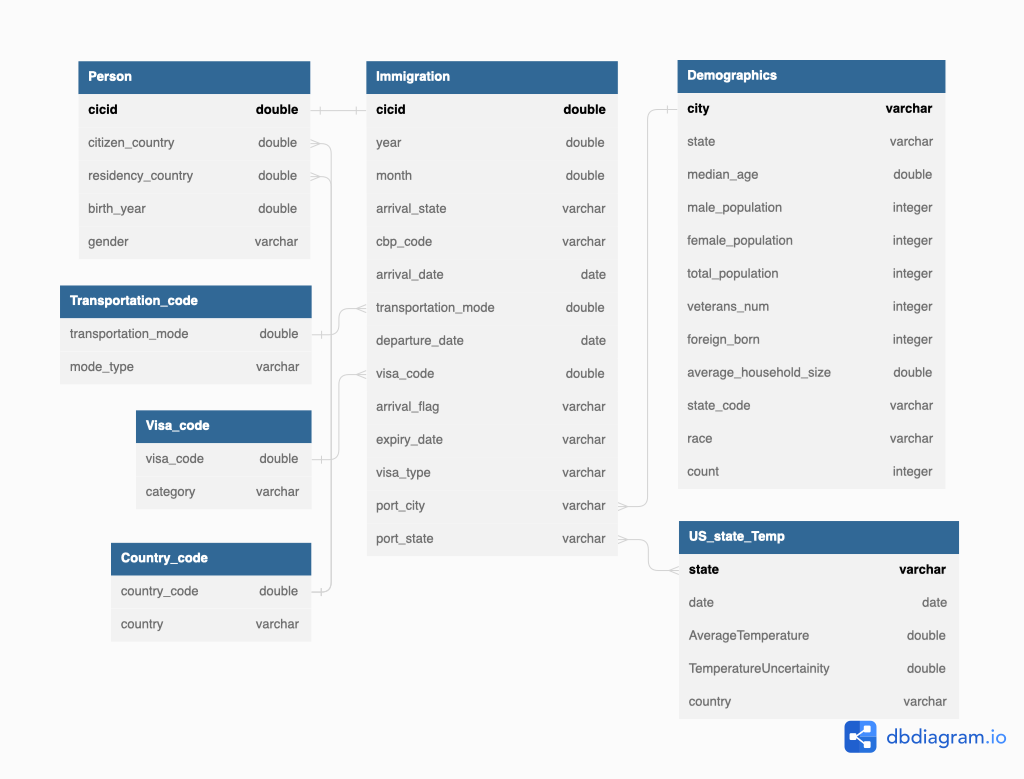

In [8]:
from IPython.display import Image
Image(filename='schema_diagram.png') 

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model

In [9]:
# run the etl.py
!python3 etl.py

https://repos.spark-packages.org/ added as a remote repository with the name: repo-1
Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
:: loading settings :: url = jar:file:/opt/spark-2.4.3-bin-hadoop2.7/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.apache.hadoop#hadoop-aws added as a dependency
saurfang#spark-sas7bdat added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-dc7da387-950c-4002-a274-1619ddb3798c;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;2.7.0 in central
	found org.apache.hadoop#hadoop-common;2.7.0 in central
	found org.apache.hadoop#hadoop-annotations;2.7.0 in central
	found com.google.guava#guava;11.0.2 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found commons-cli#commons-cli;1.2 in central
	found org.apache.commons#commons-math3;3.1.1 in central
	found xmlenc#xmlenc;0.52 in central
	found commons-httpclient#commons-httpclient;3.

#### 4.2 Data Quality Checks
1. No empty table after running ETL data pipeline

In [10]:
# run the data_quality.py
!python3 data_quality.py

Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
:: loading settings :: url = jar:file:/opt/spark-2.4.3-bin-hadoop2.7/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-6eef9b5f-9cc8-4f60-bedb-e7df6fef3356;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;2.7.0 in central
	found org.apache.hadoop#hadoop-common;2.7.0 in central
	found org.apache.hadoop#hadoop-annotations;2.7.0 in central
	found com.google.guava#guava;11.0.2 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found commons-cli#commons-cli;1.2 in central
	found org.apache.commons#commons-math3;3.1.1 in central
	found xmlenc#xmlenc;0.52 in central
	found commons-httpclient#commons-httpclient;3.1 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.4 in central
	found commo

#### 4.3 Data dictionary 

```
Immigration
	|- **cicid**  Unique number for the immigrants
	|- **year**  4 digit year
	|- **month**  Numeric month
	|- **arrival_state**  Where the immigrants resides in USA
	|- **cbp_code**  3 character code of destination USA city
	|- **arrival_date**  Date of arrrival
	|- **transportation_mode**  1 digit travel code
	|- **depature_date**  Date of depature
	|- **visa_code**  1 digit visa code
	|- **arrival_flag**  Arrival Flag - admitted or paroled into the U.S.
	|- **expiry_date**  Date to which admitted to U.S. (allowed to stay until)
	|- **visa_type**  Class of admission legally admitting the non-immigrant to temporarily stay in U.S.
	|- **port_city**  City of arrival
	|- **port_state**  State of arrival
```

```
Person
	|- **cicid**  Unique number for the immigrants
	|- **citizen_country**  3 digit code of origin country
	|- **residency_country**  3 digit code of residency country
	|- **birth_year**  Birth year of immigrant
	|- **gender**  Gender of immigrant
```

```
Demographics
	|- **city**  City
	|- **state**  State
	|- **median_age**  Median age of city
	|- **male_pop**  Male population of city
	|- **female_pop**  Female population of city
	|- **total_pop**  Total population of city
	|- **veterans_num**  Number of veterans
	|- **foreign_born**  Number of foreign born baby
	|- **average_household_size**  Average household size of city
	|- **state_code**  Code of state
	|- **race**  Race of majority
	|- **count**  Count
```

```
US_state_Temp
	|- **date**  Date
	|- **avg_temp**  Average temperature of month
	|- **avg_temp_uncertainty**  Uncertainty of average temperature of month
	|- **state**  State
	|- **country**  Country
```

```
Transportation_code
	|- **transportation_code**  1 digit travel code
	|- **mode_type**  Mode name
```

```
Visa_code
	|- **visa_code**  1 digit visa code
	|- **category**  visa category
```

```
Country_code
	|- **country_code**  3 digit code of country
	|- **country**  Country name
```

#### Step 5: Complete Project Write Up
##### Tools and Technologies:  
1. AWS S3: data storage
2. Pandas: exploratory data analysis
3. PySpark: process large dataset to extract data from local workspace to S3.

##### Data Update Frequency:  
Data should be updated monthly.

##### Future Design Considerations:
* The data was increased by 100x:
We should consider using AWS EMR to acceralate the processing speed.
* The data populates a dashboard that must be updated on a daily basis by 7am every day.
We should use the workflow management platform such as Airflow to build daily basis data pipelines.
* The database needed to be accessed by 100+ people.
We should store data into data warehouse instead of s3. There are some data warehouses options such as AWS redshift, snowflake, etc.